## Cloud type learner model

The fastai training of the a cloud phot classifier.

In [1]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 9.3 MB/s 
     |████████████████████████████████| 1.2 MB 56.1 MB/s 
     |████████████████████████████████| 362 kB 65.4 MB/s 
     |████████████████████████████████| 4.4 MB 36.1 MB/s 
     |████████████████████████████████| 1.1 MB 45.8 MB/s 
     |████████████████████████████████| 140 kB 52.6 MB/s 
     |████████████████████████████████| 86 kB 6.5 MB/s 
     |████████████████████████████████| 212 kB 75.8 MB/s 
     |████████████████████████████████| 596 kB 63.9 MB/s 
     |████████████████████████████████| 127 kB 78.3 MB/s 
     |████████████████████████████████| 94 kB 3.9 MB/s 
     |████████████████████████████████| 144 kB 71.0 MB/s 
     |████████████████████████████████| 271 kB 64.4 MB/s 
     |████████████████████████████████| 6.6 MB 39.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6

In [2]:
from fastbook import *
from fastai.vision.widgets import *

Read Microsft Azure search key from file. To download images with Bing Image Search, sign up at Microsoft Azure for a free account and get a key.

In [ ]:
with open('gdrive/MyDrive/Data_for_apps/key.txt', 'r') as f:
  lines = f.readlines()

key = os.environ.get('AZURE_SEARCH_KEY', lines[0])


Cloud types from met office https://www.metoffice.gov.uk/weather/learn-about/weather/types-of-weather/clouds/cloud-names-classifications

In [3]:
cloud_types = 'Cirrus', 'Cirrocumulus', 'Cirrostratus', 'Altocumulus', 'Altostratus', 'Nimbostratus', 'Stratocumulus', 'Stratus', 'Cumulus', 'Cumulonimbus'
cloud_height = '> 6000 m', '> 6000 m', '> 6000 m', '2000 - 6000 m', '2000 - 6000 m', '2000 - 6000 m', '< 2000 m', '< 2000 m', '< 2000 m', '< 2000 m'
path = Path('gdrive/MyDrive/Data_for_apps/Cloud_Learner/clouds')

if not path.exists():
    path.mkdir()
    for o in cloud_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} clouds')
        download_images(dest, urls=results.attrgot('contentUrl'))


Remove images that failed to download.

In [12]:
# optional
fns = get_image_files(path)
fns
#failed = verify_images(fns)
#failed.map(Path.unlink)

(#1188) [Path('gdrive/MyDrive/Data_for_apps/Cloud_Learner/clouds/Cirrostratus/cs16.jpg'),Path('gdrive/MyDrive/Data_for_apps/Cloud_Learner/clouds/Cirrostratus/cs22.jpg'),Path('gdrive/MyDrive/Data_for_apps/Cloud_Learner/clouds/Cirrostratus/cs8.jpg'),Path('gdrive/MyDrive/Data_for_apps/Cloud_Learner/clouds/Cirrostratus/cs3.jpg'),Path('gdrive/MyDrive/Data_for_apps/Cloud_Learner/clouds/Cirrostratus/cs10.JPG'),Path('gdrive/MyDrive/Data_for_apps/Cloud_Learner/clouds/Cirrostratus/cs9.JPG'),Path('gdrive/MyDrive/Data_for_apps/Cloud_Learner/clouds/Cirrostratus/cs7.JPG'),Path('gdrive/MyDrive/Data_for_apps/Cloud_Learner/clouds/Cirrostratus/cs6.jpg'),Path('gdrive/MyDrive/Data_for_apps/Cloud_Learner/clouds/Cirrostratus/cs5.jpg'),Path('gdrive/MyDrive/Data_for_apps/Cloud_Learner/clouds/Cirrostratus/cs4.JPG')...]

In [9]:
get_image_files??

In [47]:
def get_equal_images(path, folders=((),), verbose=False):
  fns = []
  min_type = 1e20
  for o in folders:
    fns_tmp = get_image_files(path, folders=o)
    if len(fns_tmp) < min_type:
      min_type = len(fns_tmp)
    if verbose:
      print(o, len(fns_tmp))

  for o in folders:
    fns_tmp = get_image_files(path, folders=o)
    random.shuffle(fns_tmp)
    fns.extend(fns_tmp[:min_type])
  return fns

fns = get_equal_images(path, cloud_types, verbose=True)
print(len(fns))

Cirrus 141
Cirrocumulus 103
Cirrostratus 98
Altocumulus 189
Altostratus 104
Nimbostratus 100
Stratocumulus 97
Stratus 109
Cumulus 117
Cumulonimbus 183
970


Make a data loader and train a model.

In [48]:
#clouds = DataBlock(
#    blocks=(ImageBlock, CategoryBlock), 
#    get_items=get_image_files, 
#    splitter=RandomSplitter(valid_pct=0.2, seed=42),
#    get_y=parent_label,
#    item_tfms=Resize(128))

clouds = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_equal_images, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

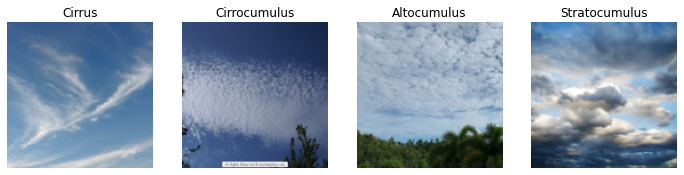

In [49]:
# optional
dls = clouds.dataloaders(path, folders=cloud_types)
dls.valid.show_batch(max_n=4, nrows=1)

In [50]:
clouds = clouds.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = clouds.dataloaders(path)


In [53]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(10)

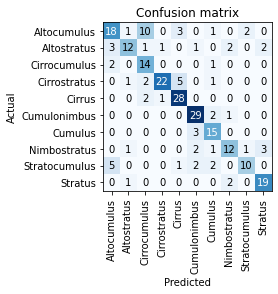

In [54]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Check the classification for bad files that are not of cloud or wrongly labeled.

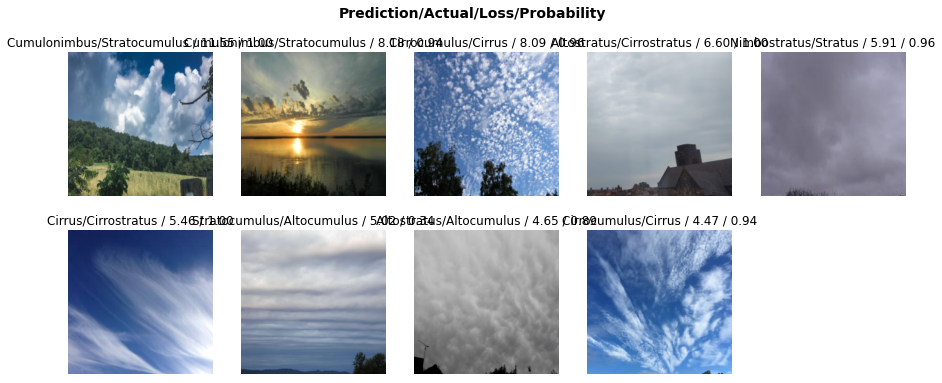

In [55]:
interp.plot_top_losses(10, nrows=2)

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

Delete bad photos or change the label. Re-run trainer after this is needed.

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
#for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

Export the model.

In [56]:
learn.export(fname='gdrive/MyDrive/Data_for_apps/Cloud_Learner/export.pkl')

!ls gdrive/MyDrive/Data_for_apps/Cloud_Learner

clouds	export.pkl
